In [1]:
import file_readin_functions as frf
import utility_functions as uf
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
import time_series_transfomer as tst
import model_analysis_test_set as mats
import seaborn as sns
import matplotlib.pyplot as plt
import monte_carlo_sim as mcs
import feature_selection as fs
import graph_visualization_functions as gvf

In [2]:
datasets = frf.all_csv_readin()

#TODO rename boolean state variables
monthly_data = False

if(monthly_data):
    datasets = uf.transform_futures_data(datasets)

lag = 3
days = 31
sequence_size= lag * days

# Monte Carlo parameters
NUM_ITERATIONS = 200  # Increased from 30 for better statistical significance
BASE_TEMP = 0.1     # Reduced from 0.1 for more stable predictions
MIN_TEMP = 0.0001     # Reduced from 0.01 for better long-term stability
DECAY_FACTOR = 0.995  # Added decay factor for temperature
CONFIDENCE_LEVELS = [0.68, 0.95]  # Standard confidence intervals (1σ and 2σ)
WINDOW_SIZE = 30      # Window size for variance calculation
FORECAST_HORIZON = 20 # Number of days to predict in backtesting
NUM_START_POINTS = 100 # Number of different starting points for backtesting

In [3]:
datasets['futures']

,Date,Change %,High,Low,Open,Price,Vol.
0,1979-12-27,-2.23,188.50,183.00,188.35,183.18,NaN
1,1979-12-28,-0.90,185.75,181.00,183.00,181.53,NaN
2,1979-12-31,0.12,182.75,181.00,182.25,181.75,NaN
3,1980-01-02,-2.29,182.25,176.00,182.10,177.58,1.14
4,1980-01-03,-3.42,176.50,170.50,176.50,171.50,1.44
...,...,...,...,...,...,...,...
11293,2024-10-17,-1.10,261.00,253.40,257.10,255.15,13.29
11294,2024-10-18,0.84,259.10,253.10,254.00,257.30,11.06
11295,2024-10-21,-2.18,254.05,248.05,253.50,251.70,16.92
11296,2024-10-22,-0.73,255.70,248.55,252.50,249.85,17.53


In [4]:
selected_features = fs.granger_feature_selector(
                        dataframes_dict=datasets,
                        alpha=0.000001,
                        f_threshold=8.0,
                        min_lag=1,
                        max_lag=lag,
                        monthly_data=monthly_data
                        )

c:\ProgramData\anaconda3\envs\Coffee_cuda\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '
c:\ProgramData\anaconda3\envs\Coffee_cuda\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '
c:\ProgramData\anaconda3\envs\Coffee_cuda\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '
c:\ProgramData\anaconda3\envs\Coffee_cuda\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank i

In [5]:
data = uf.concat_all_data(datasets, is_monthly=monthly_data, track_nans=True)
data = data[selected_features]
data = uf.fix_column_order(data, monthly_data=monthly_data, track_nans=False)

Processing dataset: disaster


c:\Users\John\Desktop\Personal Projects\Coffee Model\utility_functions.py:495: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.reindex(extended_index).fillna(method='ffill')


Processing dataset: forest


c:\Users\John\Desktop\Personal Projects\Coffee Model\utility_functions.py:495: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.reindex(extended_index).fillna(method='ffill')


Processing dataset: hdi


c:\Users\John\Desktop\Personal Projects\Coffee Model\utility_functions.py:495: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.reindex(extended_index).fillna(method='ffill')


Processing dataset: land


c:\Users\John\Desktop\Personal Projects\Coffee Model\utility_functions.py:495: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.reindex(extended_index).fillna(method='ffill')


Processing dataset: forex
Processing dataset: green_coffee


c:\Users\John\Desktop\Personal Projects\Coffee Model\utility_functions.py:495: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.reindex(extended_index).fillna(method='ffill')
c:\Users\John\Desktop\Personal Projects\Coffee Model\utility_functions.py:495: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.reindex(extended_index).fillna(method='ffill')


Processing dataset: futures


In [6]:
data

,Date,Price
0,1979-12-27,183.18
1,1979-12-28,181.53
2,1979-12-29,NaN
3,1979-12-30,NaN
4,1979-12-31,181.75
...,...,...
16368,2024-10-19,NaN
16369,2024-10-20,NaN
16370,2024-10-21,251.70
16371,2024-10-22,249.85


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize dataset and prepare data
dataset = tst.TimeSeriesDataset(sequence_size=sequence_size)
data_loaders = dataset.prepare_data(data)
x_test = dataset.x_test
test_data = dataset.test_data

Initial data shape: (16373, 2)
After dropna shape: (11298, 2)
Train index: 9038
Total data length: 11298
Test data shape: (2260, 2)


c:\Users\John\Desktop\Personal Projects\Coffee Model\time_series_transfomer.py:221: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:278.)
  x_tensor = torch.tensor(x, dtype=torch.float32).view(-1, self.sequence_size, num_features)


In [8]:
# num_layers = 2 * sequence_size for full run

# Initialize model and trainer
model = tst.TransformerModel(
    input_dim=len(data.columns)-1,
    d_model=32,
    nhead=4,
    num_layers = 1,
    dropout=0.1
).to(device)


# Run training
trainer = tst.ModelTrainer(
    model, 
    device, 
    loss_config={
        'type': 'forecast_based',
        'forecast_steps': 10,
        'forecast_weight': 0.30,
        'direction_weight': 0.68,
        'volatility_weight': 0.02,
        'temperature': 0.3,
        'num_samples': 10
    })
trainer.train(data_loaders, patience=10, epochs=1000)

c:\ProgramData\anaconda3\envs\Coffee_cuda\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
c:\ProgramData\anaconda3\envs\Coffee_cuda\Lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch 1/1000
Train Loss: 0.4327, Val Loss: 0.3457, LR: 0.00010000
Epoch 2/1000
Train Loss: 0.3359, Val Loss: 0.3276, LR: 0.00010000
Epoch 3/1000
Train Loss: 0.3108, Val Loss: 0.3162, LR: 0.00010000
Epoch 4/1000
Train Loss: 0.3009, Val Loss: 0.3071, LR: 0.00010000
Epoch 5/1000
Train Loss: 0.2943, Val Loss: 0.3054, LR: 0.00010000
Epoch 6/1000
Train Loss: 0.2935, Val Loss: 0.3060, LR: 0.00010000
Epoch 7/1000
Train Loss: 0.2904, Val Loss: 0.2980, LR: 0.00010000
Epoch 8/1000
Train Loss: 0.2909, Val Loss: 0.2969, LR: 0.00010000
Epoch 9/1000
Train Loss: 0.2905, Val Loss: 0.2949, LR: 0.00010000
Epoch 10/1000
Train Loss: 0.2909, Val Loss: 0.2949, LR: 0.00010000
Epoch 11/1000
Train Loss: 0.2902, Val Loss: 0.2961, LR: 0.00010000
Epoch 12/1000
Train Loss: 0.2878, Val Loss: 0.2980, LR: 0.00010000
Epoch 13/1000
Train Loss: 0.2876, Val Loss: 0.2926, LR: 0.00010000
Epoch 14/1000
Train Loss: 0.2882, Val Loss: 0.2934, LR: 0.00010000
Epoch 15/1000
Train Loss: 0.2876, Val Loss: 0.2924, LR: 0.00010000
Epoc

{'epochs': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46],
 'train_loss': [0.43265856423282195,
  0.3358612931998713,
  0.310773219514106,
  0.30086159273715957,
  0.2943152932317129,
  0.2935454597297524,
  0.29037117964721154,
  0.29090912101258126,
  0.2904909817901041,
  0.2909062609209546,
  0.29021862322198494,
  0.2878297329880297,
  0.2876031213839139,
  0.2881658878842635,
  0.28759791808468954,
  0.29010479032461134,
  0.287153844255954,
  0.2876534215839846,
  0.287645106070808,
  0.28734048562390463,
  0.2876546030997166,
  0.2866811103719686,
  0.28721284872985314,
  0.2868730071266847,
  0.2867072490043938,
  0.2859664001236005,
  0.2881637767090329,
  0.2857010491591479,
  0.286100646547441,
  0.2860727062049721,
  0.2863534144125879,
  0.285585025658

c:\ProgramData\anaconda3\envs\Coffee_cuda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\envs\Coffee_cuda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\envs\Coffee_cuda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\envs\Coffee_cuda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

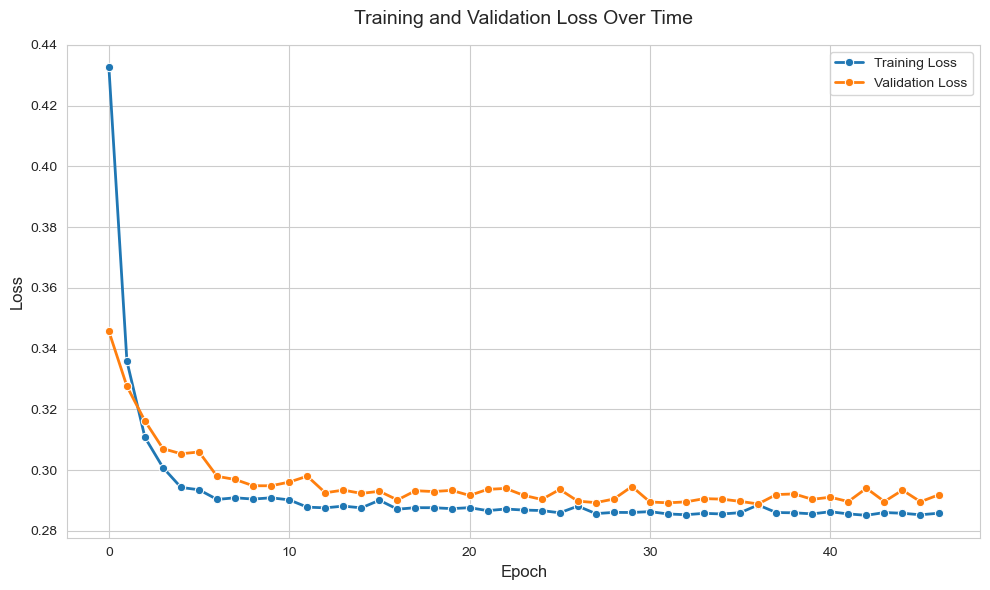

In [9]:
mats.plot_training_history(trainer)

In [10]:
# Run evaluation
predictions, true_values, rmse, dates = mats.evaluate_test_set(model, data_loaders['test'], dataset.scaler, dataset.test_data, dataset.sequence_size)



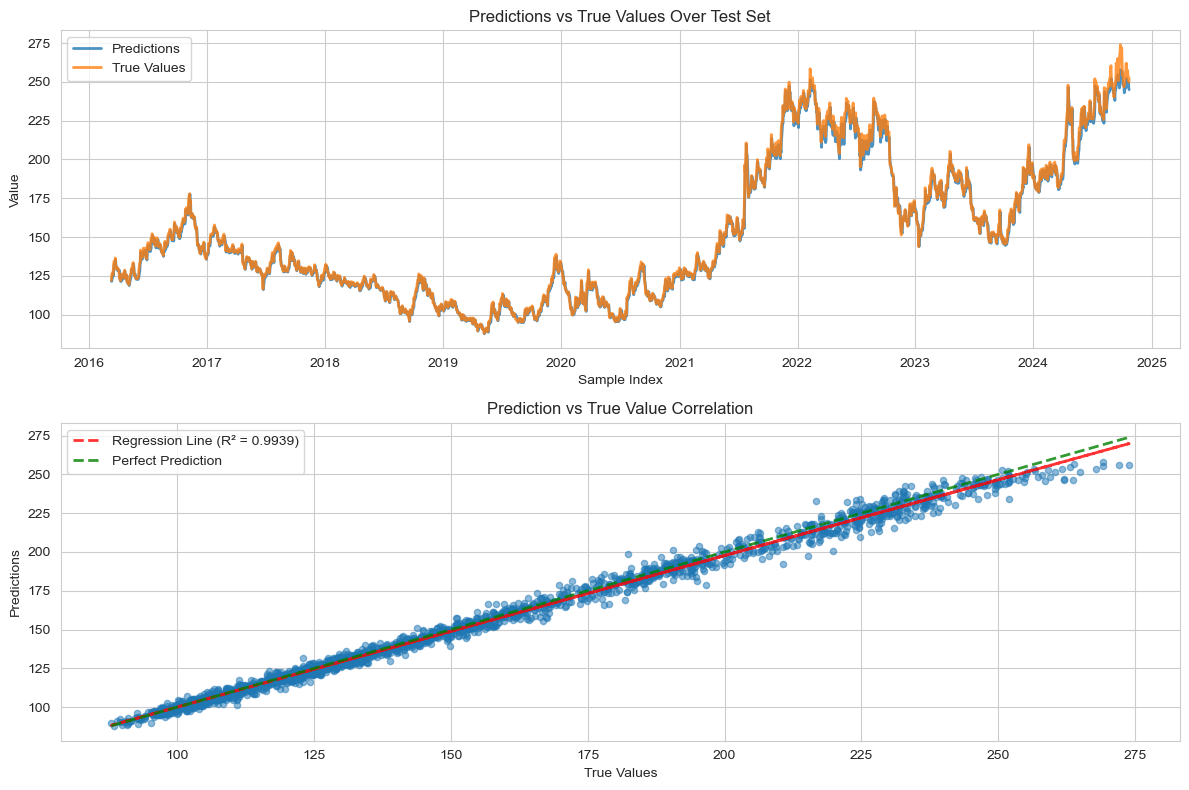


Metrics:
RMSE: 3.7898
MAE: 2.6663
R²: 0.9939


In [11]:
# Create visualizations
mats.plot_predictions(predictions, true_values, test_data, sequence_size)

In [12]:
forecaster = mcs.MonteCarloForecaster(
    model  = trainer.model,
    scaler = dataset.scaler,
    device = device,
    sequence_size = sequence_size
)

In [13]:
remaining_days_data = forecaster.monte_carlo_forecast(
    x_test=x_test,
    num_iterations=NUM_ITERATIONS,
    num_days_to_predict=2*365,
    base_temp=BASE_TEMP,
    decay_factor=DECAY_FACTOR,
    min_temp=MIN_TEMP,
    confidence_levels=CONFIDENCE_LEVELS
    )

Processed start index 0/200
Processed start index 1/200
Processed start index 2/200
Processed start index 3/200
Processed start index 4/200
Processed start index 5/200
Processed start index 6/200
Processed start index 7/200
Processed start index 8/200
Processed start index 9/200
Processed start index 10/200
Processed start index 11/200
Processed start index 12/200
Processed start index 13/200
Processed start index 14/200
Processed start index 15/200
Processed start index 16/200
Processed start index 17/200
Processed start index 18/200
Processed start index 19/200
Processed start index 20/200
Processed start index 21/200
Processed start index 22/200
Processed start index 23/200
Processed start index 24/200
Processed start index 25/200
Processed start index 26/200
Processed start index 27/200
Processed start index 28/200
Processed start index 29/200
Processed start index 30/200
Processed start index 31/200
Processed start index 32/200
Processed start index 33/200
Processed start index 34

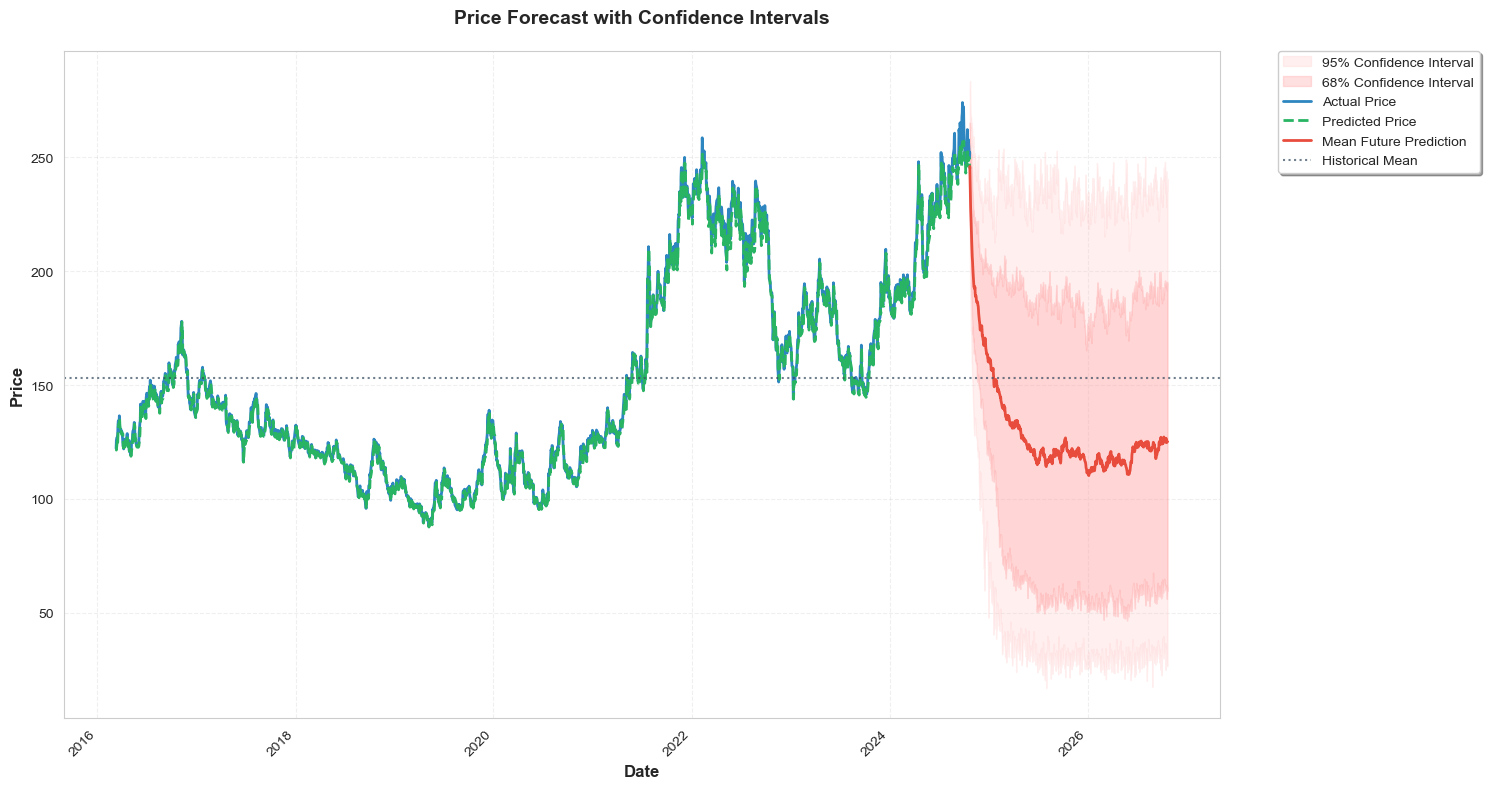

In [14]:
forecaster.monte_carlo_forecast_plot(   remaining_days_data = remaining_days_data, 
                                        predictions         = predictions, 
                                        test_data           = test_data,
                                        DateMax=2*365
                                        )

In [15]:
forecast_results = forecaster.monte_carlo_backtesting(  
    test_data=test_data,
    x_test=x_test,
    forecast_horizon=FORECAST_HORIZON,
    num_simulations=NUM_ITERATIONS,
    num_start_points=NUM_START_POINTS,
    base_temperature=BASE_TEMP,
    temperature_decay=DECAY_FACTOR,
    min_temperature=MIN_TEMP,
    confidence_levels=CONFIDENCE_LEVELS
    )

Processed start index 0/2146
Processed start index 21/2146
Processed start index 43/2146
Processed start index 65/2146
Processed start index 86/2146
Processed start index 108/2146
Processed start index 130/2146
Processed start index 151/2146
Processed start index 173/2146
Processed start index 195/2146
Processed start index 216/2146
Processed start index 238/2146
Processed start index 260/2146
Processed start index 281/2146
Processed start index 303/2146
Processed start index 325/2146
Processed start index 346/2146
Processed start index 368/2146
Processed start index 390/2146
Processed start index 411/2146
Processed start index 433/2146
Processed start index 455/2146
Processed start index 476/2146
Processed start index 498/2146
Processed start index 520/2146
Processed start index 541/2146
Processed start index 563/2146
Processed start index 585/2146
Processed start index 606/2146
Processed start index 628/2146
Processed start index 650/2146
Processed start index 671/2146
Processed star

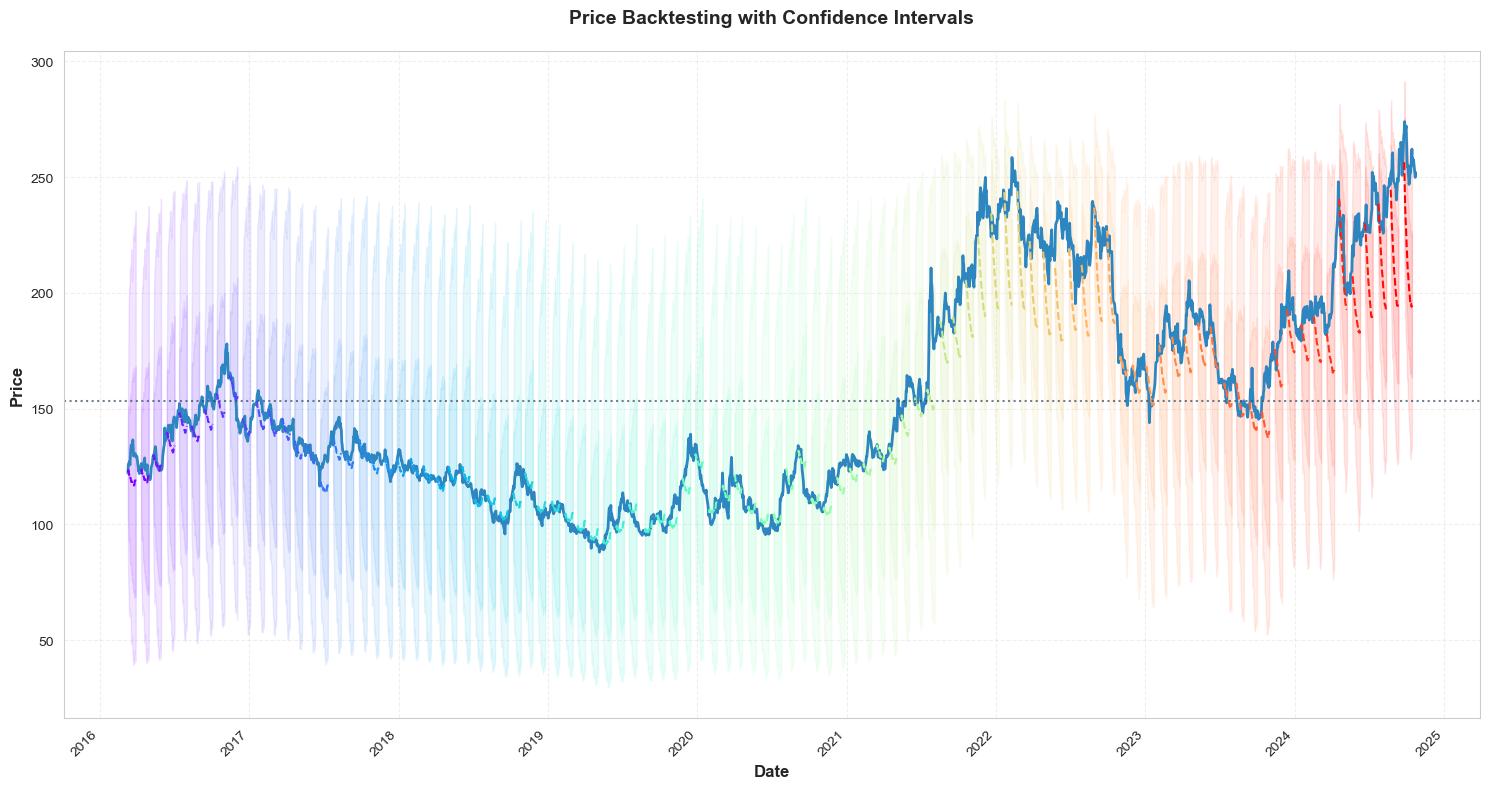

In [16]:
forecaster.monte_carlo_backtesting_plot(backtesting_results = forecast_results, 
                                        x_test=x_test,
                                        forecast_horizon=FORECAST_HORIZON,
                                        num_start_points=NUM_START_POINTS,
                                        test_data = test_data)

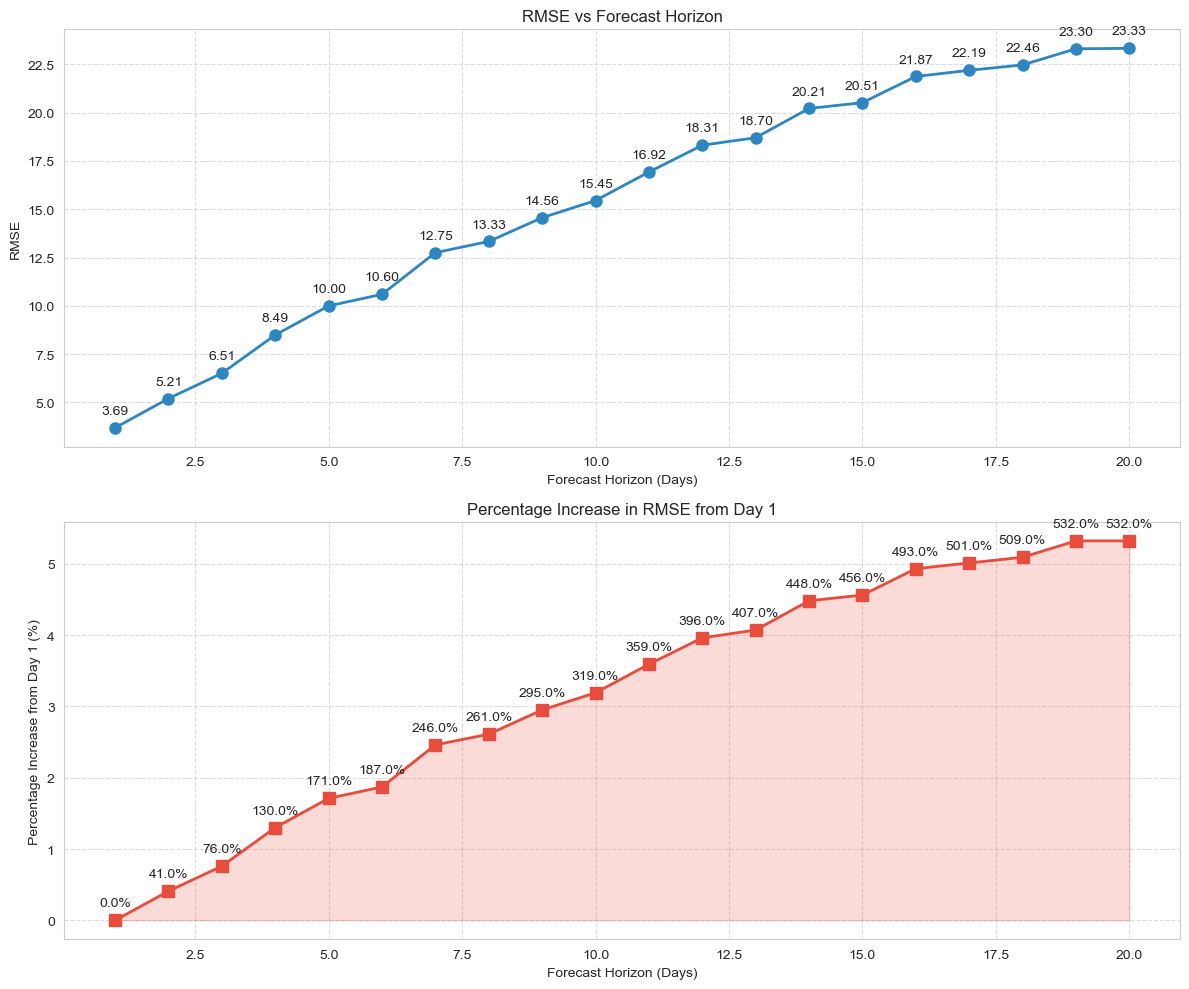

In [17]:
forecaster.monte_carlo_backtesting_diagnotsics_plot(forecast_results = forecast_results,
                                                    test_data = test_data)

c:\Users\John\Desktop\Personal Projects\Coffee Model\monte_carlo_sim.py:1130: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(


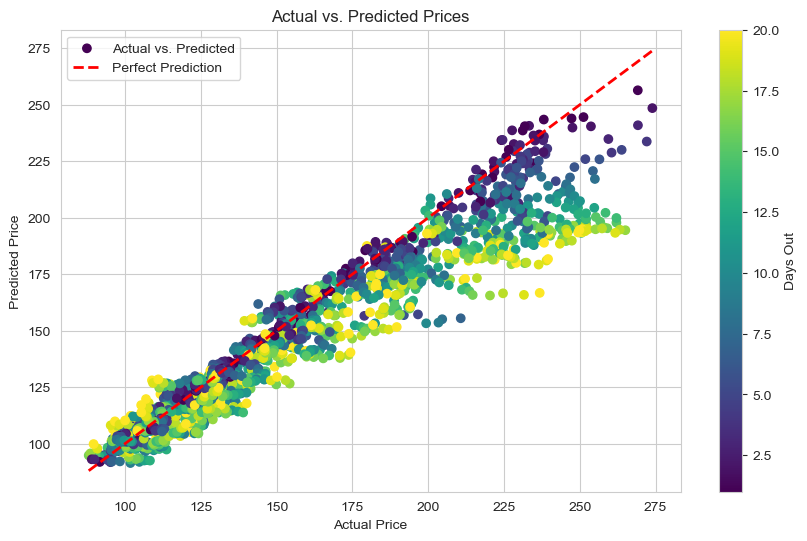

In [18]:
forecaster.monte_carlo_backtesting_pred_true_plot(  forecast_results = forecast_results,
                                                    test_data = test_data)

c:\ProgramData\anaconda3\envs\Coffee_cuda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\envs\Coffee_cuda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\envs\Coffee_cuda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\envs\Coffee_cuda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

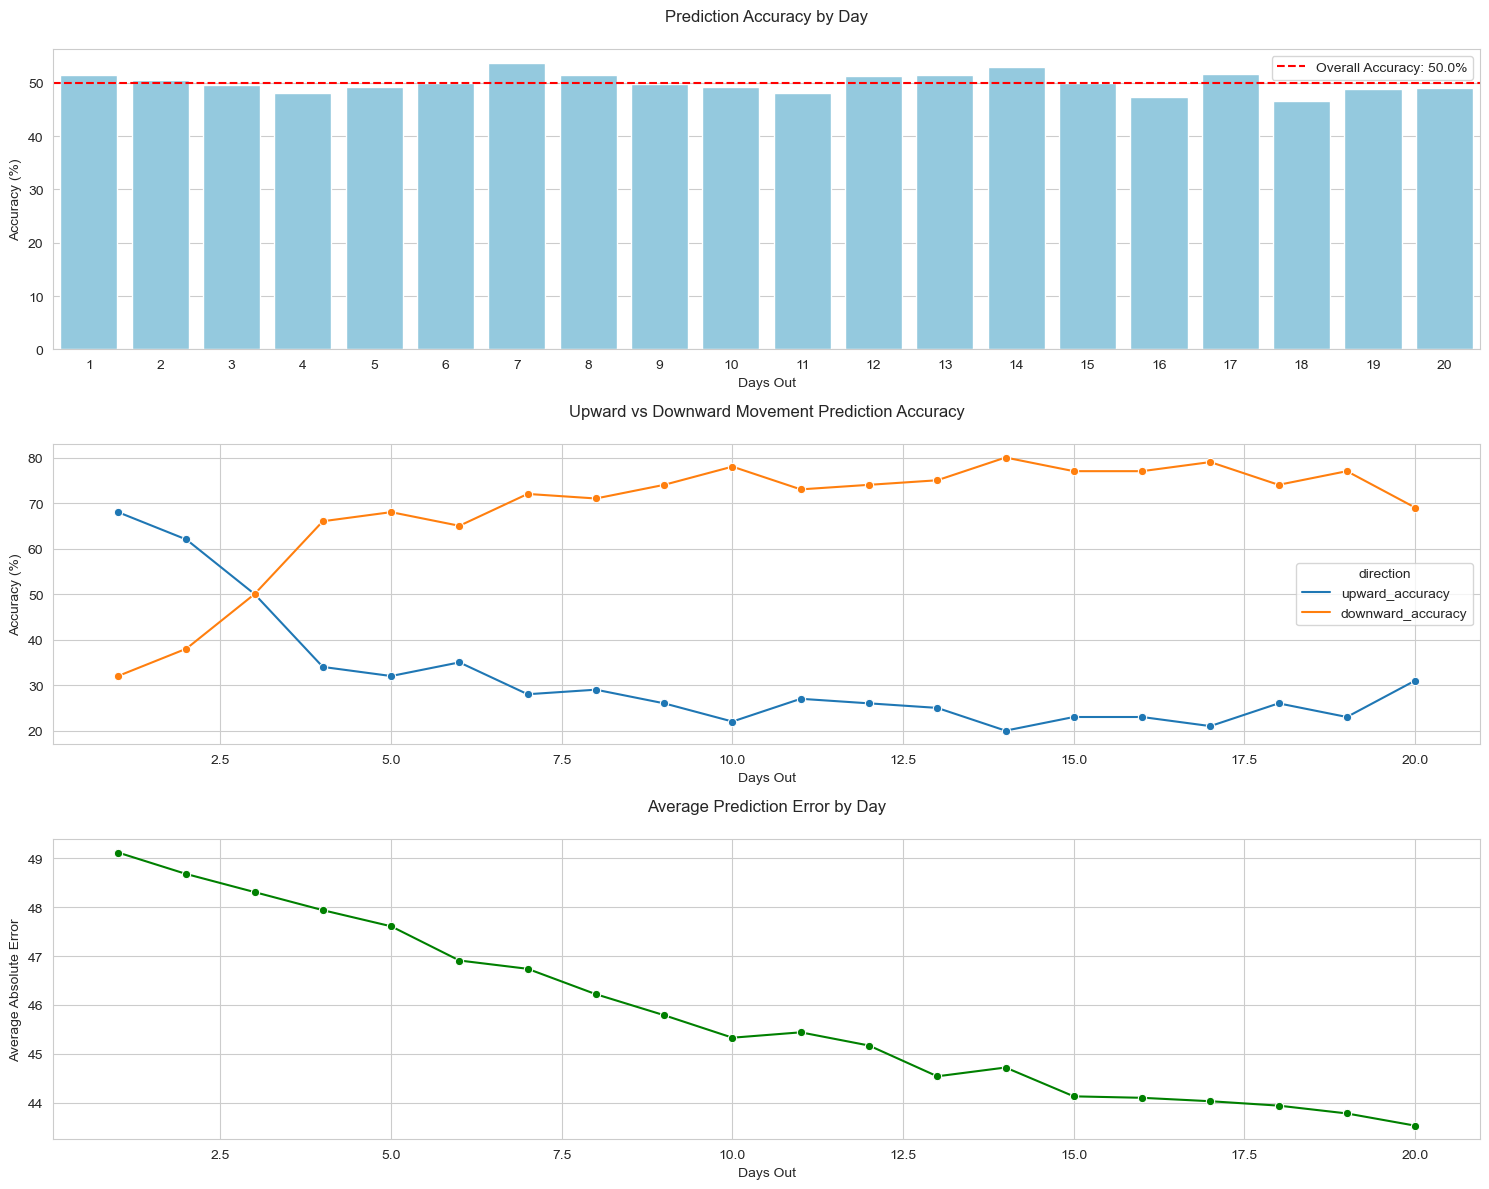


Detailed Performance Metrics:
MAPE: 29.92%
RMSE: 58.04
Direction Bias: -0.368


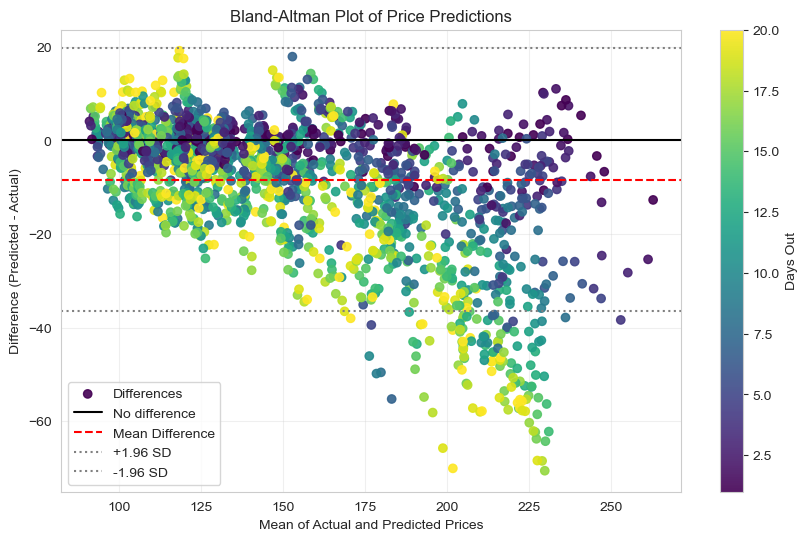

Mean difference: -8.39
Upper limit of agreement: 19.71
Lower limit of agreement: -36.50

Accuracy Analysis by Time Blocks:
   block  slope_match_count  total_comparisons  slope_match_percentage  \
0      0            10202.0            20000.0                  51.010   
1      1             9756.0            20000.0                  48.780   
2      2             9923.0            20000.0                  49.615   
3      3            10507.0            20000.0                  52.535   
4      4             9896.0            20000.0                  49.480   
5      5             9934.0            20000.0                  49.670   
6      6            10450.0            20000.0                  52.250   
7      7             9738.0            20000.0                  48.690   
8      8             9833.0            20000.0                  49.165   
9      9             9785.0            20000.0                  48.925   

   avg_prediction_error  
0             48.898017  
1         

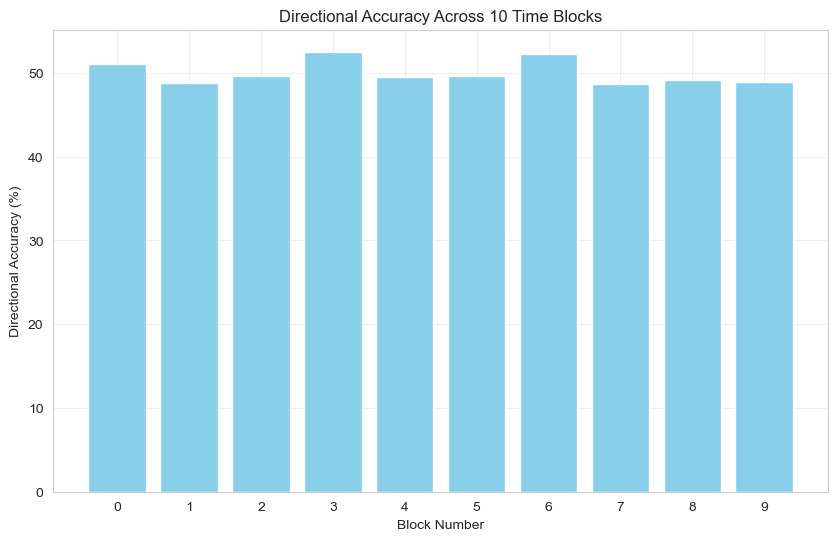


Accuracy Analysis by Price Range:
   price_block  slope_match_count  total_comparisons  slope_match_percentage  \
0            0            10419.0            20000.0               52.095000   
1            1            10373.0            20000.0               51.865000   
2            2            10035.0            20000.0               50.175000   
3            3             9834.0            20000.0               49.170000   
4            4             9899.0            20100.0               49.248756   
5            5             9866.0            19900.0               49.577889   
6            6             9795.0            20000.0               48.975000   
7            7            10554.0            20100.0               52.507463   
8            8            10048.0            19900.0               50.492462   
9            9             9201.0            20000.0               46.005000   

   price_min  price_max  avg_prediction_error  
0      88.00     103.40             

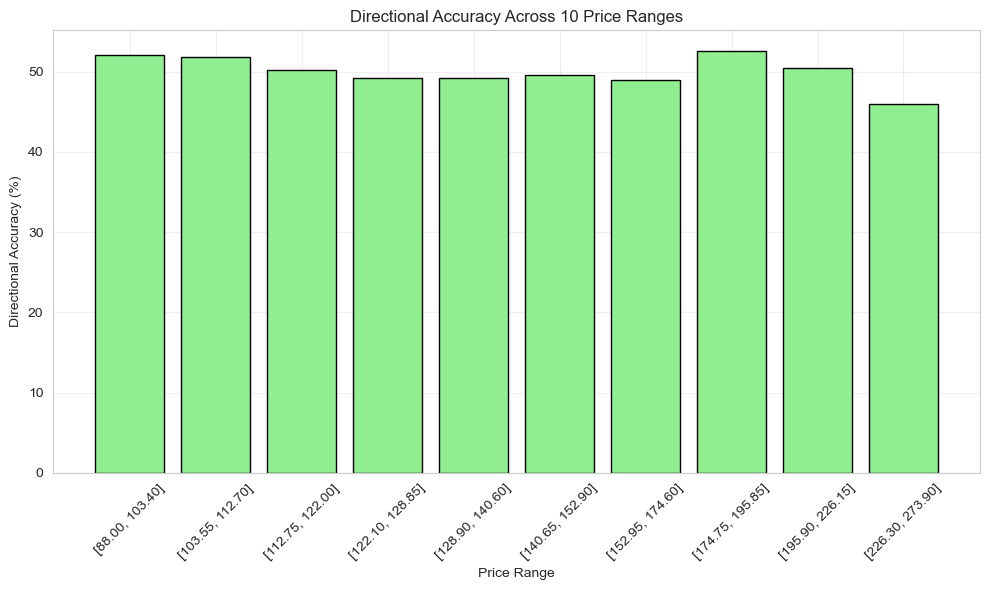

In [19]:
# Calculate accuracy metrics
results = mats.calculate_directional_accuracy(test_data, forecast_results, sequence_size)

# Plot various visualizations
mats.plot_accuracy_metrics(results['accuracy_by_day'], results['detailed_metrics'])
mats.bland_altman_plot(sequence_size, forecast_results, test_data)

# Analyze accuracy by blocks and price ranges
block_analysis = mats.analyze_accuracy_by_blocks(results['detailed_results'])
price_analysis = mats.analyze_accuracy_by_price_range(results['detailed_results'])

In [45]:
import json
import os
from pathlib import Path

# Run the decoder tuning grid
print("Starting decoder tuning...")
tuning_results = tst.run_decoder_tuning(
    data=data,
    sequence_size=10,
    d_model=32,
    nhead=4,
    num_layers=1,
    dropout=0.2,
    learning_rate=1e-4,
    epochs=1000,
    patience=10,
    plot_training=False
)

# Get the experiment path and top models
experiment_path = tuning_results["experiment_path"]
top_models = tuning_results["top_models"]

print(f"Decoder tuning completed. Results saved at: {experiment_path}")
print(f"Top 5 models found with the following validation losses:")
for i, model_info in enumerate(top_models):
    print(f"Model {i+1}: val_loss = {model_info['val_loss']:.6f}")

# Create a dataset for testing
dataset = tst.TimeSeriesDataset(sequence_size=10)  # Use the same sequence_size as in tuning
data_loaders = dataset.prepare_data(data)

# Get the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Analyze each of the top 5 models
for i, model_info in enumerate(top_models):
    print(f"\n{'='*50}")
    print(f"Analyzing Model {i+1}")
    print(f"{'='*50}")
    
    # Load the model
    model_path = os.path.join(experiment_path, f"best_model_{i+1}.pth")
    
    # Create model with the same configuration
    config = model_info["config"]
    model = tst.TransformerModel(
        input_dim=len(data.columns) - 1, 
        d_model=32,  # Use the same as in tuning
        nhead=4,
        num_layers=1,
        dropout=0.2,
        decoder_config=config
    ).to(device)
    
    # Load the saved weights
    model.load_state_dict(torch.load(model_path))
    
    # Evaluate the model on the test set an extract the results
    predictions, true_values, rmse, dates = mats.evaluate_test_set(
        model=model,
        test_loader=data_loaders['test'],
        scaler=dataset.scaler,
        test_data=dataset.test_data,
        sequence_size=dataset.sequence_size,
        device=device
    )
    
    print(f"Model {i+1} Test RMSE: {rmse:.4f}")
    
    # Plot predictions
    print("\nPrediction vs True Values Plot:")
    mats.plot_predictions(
        predictions=predictions,
        true_values=true_values,
        test_data=dataset.test_data,
        sequence_size=dataset.sequence_size
    )
    
    # Run Monte Carlo forecasting
    print("\nRunning Monte Carlo backtesting...")
    mc_forecaster = mcs.MonteCarloForecaster(
        model=model,
        scaler=dataset.scaler,
        device=device,
        sequence_size=dataset.sequence_size
    )
    
    # Perform backtesting
    forecast_results = mc_forecaster.monte_carlo_backtesting(
        test_data=dataset.test_data,
        x_test=dataset.x_test,
        num_days_to_predict=20,
        num_iterations=30,
        num_forecast_points=50
    )
    
    mc_forecaster.monte_carlo_backtesting_plot(
        forecast_results = forecast_results, 
        x_test=dataset.x_test,
        num_days_to_predict=20,
        num_forecast_points=10,
        test_data = dataset.test_data
    )
    
    accuracy_results = mats.calculate_directional_accuracy(
        test_data=dataset.test_data,
        forecast_results=forecast_results,
        sequence_size=dataset.sequence_size
    )
    
    print("\nDirectional Accuracy Metrics:")
    mats.plot_accuracy_metrics(
        accuracy_by_day=accuracy_results['accuracy_by_day'],
        detailed_metrics=accuracy_results['detailed_metrics']
    )
    
    detailed_results = accuracy_results['detailed_results']
    
    print("\nAccuracy Analysis by Time Blocks:")
    block_analysis = mats.analyze_accuracy_by_blocks(detailed_results, n=5)
    
    print("\nAccuracy Analysis by Price Range:")
    price_analysis = mats.analyze_accuracy_by_price_range(detailed_results, n=5)
    
    print("\nGenerating future forecast...")
    future_forecast = mc_forecaster.monte_carlo_forecast(
        x_test=dataset.x_test,
        num_days_to_predict=100,
        num_iterations=1000
    )
    
    mc_forecaster.monte_carlo_forecast_plot(   
        remaining_days_data = future_forecast, 
        predictions         = predictions, 
        test_data           = dataset.test_data,
        DateMax=2*365
        )
    
    # Save analysis results for this model
    model_analysis_dir = os.path.join(experiment_path, f"model_{i+1}_analysis")
    os.makedirs(model_analysis_dir, exist_ok=True)
    
    # Save metrics
    metrics = {
        "rmse": float(rmse),
        "directional_accuracy": accuracy_results['overall_accuracy'],
        "detailed_metrics": accuracy_results['detailed_metrics']
    }
    
    with open(os.path.join(model_analysis_dir, "metrics.json"), "w") as f:
        json.dump(uf.convert_to_serializable(metrics), f, indent=4)
    
    print(f"\nAnalysis for Model {i+1} completed and saved to {model_analysis_dir}")

print("\nAll models analyzed successfully!")

Starting decoder tuning...
Initial data shape: (16373, 2)
After dropna shape: (11298, 2)
Train index: 9038
Total data length: 11298
Test data shape: (2260, 2)
Model 1 of 4: 25.00% done

TRAINING MODEL WITH CONFIGURATION:
Base parameters:
  - Input dimensions: 1
  - Embedding dimension (d_model): 32
  - Attention heads (nhead): 4
  - Transformer layers: 1
  - Dropout rate: 0.2000
  - Learning rate: 0.0001
  - Loss function: custom

Decoder configuration:
  - Layer architecture: [(16, 'rrelu'), (8, 'rrelu'), (1, None)]
  - Batch normalization: False
  - Decoder dropout: 0.2000



c:\ProgramData\anaconda3\envs\Coffee_cuda\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/1000
Train Loss: 0.7045, Val Loss: 0.5113, LR: 0.00010000
Epoch 2/1000
Train Loss: 0.4722, Val Loss: 0.4966, LR: 0.00010000
Epoch 3/1000
Train Loss: 0.3953, Val Loss: 0.4872, LR: 0.00010000
Epoch 4/1000
Train Loss: 0.3346, Val Loss: 0.4907, LR: 0.00010000
Epoch 5/1000
Train Loss: 0.2996, Val Loss: 0.4840, LR: 0.00010000
Epoch 6/1000
Train Loss: 0.2869, Val Loss: 0.4839, LR: 0.00010000
Epoch 7/1000
Train Loss: 0.2843, Val Loss: 0.4821, LR: 0.00010000
Epoch 8/1000
Train Loss: 0.2708, Val Loss: 0.4798, LR: 0.00010000
Epoch 9/1000
Train Loss: 0.2672, Val Loss: 0.4803, LR: 0.00010000
Epoch 10/1000
Train Loss: 0.2673, Val Loss: 0.4794, LR: 0.00010000
Epoch 11/1000
Train Loss: 0.2617, Val Loss: 0.4797, LR: 0.00010000
Epoch 12/1000
Train Loss: 0.2595, Val Loss: 0.4805, LR: 0.00010000
Epoch 13/1000
Train Loss: 0.2617, Val Loss: 0.4795, LR: 0.00010000
Epoch 14/1000
Train Loss: 0.2461, Val Loss: 0.4800, LR: 0.00010000
Epoch 15/1000
Train Loss: 0.2541, Val Loss: 0.4798, LR: 0.00010000
Epoc

KeyboardInterrupt: 